# Titanic: Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')
df = pd.concat([train, test], sort=True).reset_index(drop=True)
print(len(train),len(test),len(submit),len(df))

891 418 418 1309


#### Check for null data

In [3]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

TODO:<br>
1) Only first class passengers can have a cabin, so cabin feature is not useful.
    However, the cabin letters could indicate what floor level each passenger is at. Cabin A is at the top, so it is closest to the deck where the lifeboats are. As a result, it could be useful to use Cabin letters. <br>

### Feature engineering and Feature Selection

In [4]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [5]:
# transform cabin column into holding only cabin floor
#df.loc[df['Cabin'].isna()==True,'Cabin'] = 'Z'
test.loc[test['Cabin'].isna()==True,'Cabin'] = 'Z'
train.loc[train['Cabin'].isna()==True,'Cabin'] = 'Z'
def split(word):
    return [char for char in word]

In [6]:
train['Cabin'] = [split(i) for i in train['Cabin']]
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Z']
a = []
for i in train['Cabin']:
    b = []
    for j in i:
        if j in cabin_list:
            b.append(j)
    a.append(b)
train['Cabin'] = a
# select the highest deck for passengers with multiple decks booked
train['Cabin'] = [min(i) for i in train['Cabin']]

test['Cabin'] = [split(i) for i in test['Cabin']]
a = []
for i in test['Cabin']:
    b = []
    for j in i:
        if j in cabin_list:
            b.append(j)
    a.append(b)
test['Cabin'] = a
test['Cabin'] = [min(i) for i in test['Cabin']]

In [7]:
train['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [8]:
train[(train['Parch']==0) & (train['Age'].isna()==True)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Z,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,Z,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,Z,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,Z,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Z,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C,C
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C,C
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,Z,C
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,Z,S


Most of the nan values for age can be solved using Parch

In [9]:
test.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin           0
Embarked        0
dtype: int64

#### "Some children travelled only with a nanny, therefore parch=0 for them" source kaggle variable notes

In [10]:
# Add column age range 
train['AgeRange'] = None
train.loc[train['Age']<13,'AgeRange'] = 'Child'
train.loc[(train['Age']>=13)&(train['Age']<21),'AgeRange'] = 'Teen'
train.loc[train['Age']>=21,'AgeRange'] = 'Adult'
train.loc[(train['Parch']==0)&(train['Age'].isna()==True),'AgeRange'] = 'Child'
train.loc[train['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'
# drop Age column
#train = train.drop(['Age'], axis=1) 
test['AgeRange'] = None
test.loc[test['Age']<13,'AgeRange'] = 'Child'
test.loc[(test['Age']>=13)&(test['Age']<21),'AgeRange'] = 'Teen'
test.loc[test['Age']>=21,'AgeRange'] = 'Adult'
test.loc[(test['Parch']==0)&(test['Age'].isna()==True),'AgeRange'] = 'Child'
test.loc[test['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'

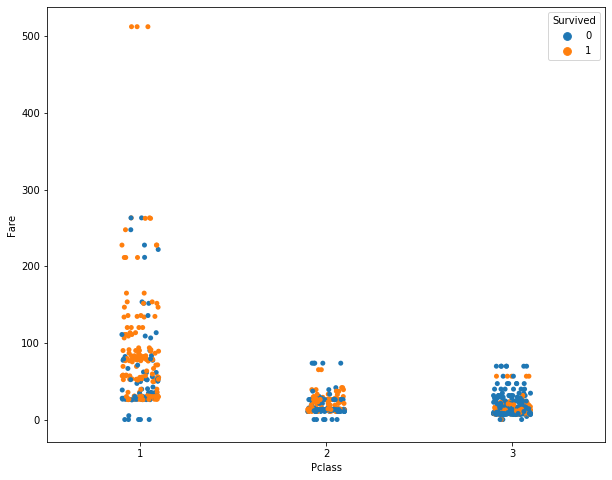

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt
# check relation between fare price and Pclass
plt.figure(figsize=(10, 8))
sns.stripplot(x='Pclass',y='Fare',hue='Survived',data=train)
plt.show()

#### Observations:
1) Fare price does not relate to the ticket class unless fare is above 100 <br>
2) For fare above 100, 1st class has more % of survivers than that of 1st class tickets below 100 <br> 
2) 1st and 2nd class ticket holders have more survivers than 3rd class <br>

In [12]:
print(train.groupby('Survived')['Cabin'].value_counts().unstack().fillna(0))

Cabin       A     B     C     D     E    F    G    T      Z
Survived                                                   
0         8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1         7.0  35.0  35.0  25.0  25.0  7.0  2.0  0.0  206.0


It was expected that as Cabin number would increase from A to T the number of survived would decrease as lower letter Cabins are closer to the the deck (where life boats are). 

In [13]:
print(round(train.groupby('Cabin')['Fare'].mean()))
print(round(train.groupby('Cabin')['Fare'].median()))

Cabin
A     40.0
B    114.0
C    100.0
D     57.0
E     45.0
F     18.0
G     14.0
T     36.0
Z     19.0
Name: Fare, dtype: float64
Cabin
A    36.0
B    80.0
C    83.0
D    53.0
E    38.0
F    12.0
G    14.0
T    36.0
Z    10.0
Name: Fare, dtype: float64


Note: Cabin Z is 2nd and 3rd class <br>
#### Observations:
1) looking at the mean and median fare for each cabin, and comparing it to the Survived count table, Cabin B,C and D are most expensive cabins and they also have the highest Survival rate. <br>
2) Since fare value is significant to 5 decimal places using it will make the model too complex. To simplify model building, either use a similified version of fare value or use cabin column and fare column to create a new feature.

In [14]:
# add feature avg price of a cabin (calculated as int)
avg = round(train.groupby('Cabin')['Fare'].mean())
avg = {j:i for i,j in zip(avg,train['Cabin'].unique())}
train['Fare_avg'] = [avg[i] for i in train['Cabin']]

avg = round(test.groupby('Cabin')['Fare'].mean())
avg = {j:i for i,j in zip(avg,test['Cabin'].unique())}
test['Fare_avg'] = [avg[i] for i in test['Cabin']]

In [15]:
print(train.groupby('Survived')['Embarked'].value_counts().unstack().fillna(0))

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


In [16]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer']
a = [i.strip().split() for i in train['Name']]
a = [j for i in a for j in i if '.' in j]
a = pd.DataFrame(a)
a[0].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Jonkheer.      1
L.             1
Mme.           1
Ms.            1
Sir.           1
Lady.          1
Capt.          1
Countess.      1
Don.           1
Name: 0, dtype: int64

In [17]:
a = a[a[0]!='L.']
train['Title'] = a

In [18]:
train[train['Title'].isna()==True][['Name','Title']]

,Name,Title
514,"Coleff, Mr. Satio",NaN


In [19]:
train.loc[514,'Title'] = 'Mr.'
#train.loc[890,'Title'] = 'Mr.'

In [20]:
a = [i.strip().split() for i in test['Name']]
a = [j for i in a for j in i if '.' in j]
a = pd.DataFrame(a)
a[0].value_counts()

Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Ms.          1
Dr.          1
Dona.        1
Name: 0, dtype: int64

In [21]:
test['Title'] = a[a[0]!='Dona.']

In [22]:
test[test['Title'].isna()==True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeRange,Fare_avg,Title
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C,C,Adult,71.0,NaN


In [23]:
# assume it is Ms
test.loc[414,'Title'] = 'Ms.'

### one hot encoding

In [24]:
# simplify code using encode = ['Sex','AgeRange','Cabin']
dummies = pd.get_dummies(train.Sex)
for i in train['Sex'].unique():
    train[i] = 0
for i in train['Sex'].unique():
    train.loc[:,i] =  dummies[i]
#train = train.drop(['Sex'], axis=1) 
train.head()
dummies = pd.get_dummies(test.Sex)
for i in test['Sex'].unique():
    test[i] = 0
for i in test['Sex'].unique():
    test.loc[:,i] =  dummies[i]

#test = test.drop(['Sex'], axis=1) 

In [25]:
# one hot encoding for age
dummies = pd.get_dummies(train.AgeRange)
for i in train['AgeRange'].unique():
    train[i] = 0
for i in train['AgeRange'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.AgeRange)
for i in test['AgeRange'].unique():
    test[i] = 0

for i in test['AgeRange'].unique():
    test.loc[:,i] =  dummies[i]

In [26]:
# one hot encoding for Cabin
dummies = pd.get_dummies(train.Cabin)
for i in train['Cabin'].unique():
    train[i] = 0
for i in train['Cabin'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.Cabin)
for i in test['Cabin'].unique():
    test[i] = 0

for i in test['Cabin'].unique():
    test.loc[:,i] =  dummies[i]

In [27]:
# one hot encoding for Title
dummies = pd.get_dummies(train.Title)
for i in train['Title'].unique():
    train[i] = 0
for i in train['Title'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.Title)
for i in test['Title'].unique():
    test[i] = 0

for i in test['Title'].unique():
    test.loc[:,i] =  dummies[i]

In [28]:
train[train['Embarked'].isna()==True][['Name','Sex','Ticket','Embarked','Cabin']]

,Name,Sex,Ticket,Embarked,Cabin
61,"Icard, Miss. Amelie",female,113572,NaN,B
829,"Stone, Mrs. George Nelson (Martha Evelyn)",female,113572,NaN,B


 After google one of the passengers (https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) found that the Embarked value is 'S' since the other passenger has the same ticket number means they travelled together and so both Embarked from the same location

In [29]:
train['Embarked'] = train['Embarked'].fillna('S')

In [30]:
# one hot encoding for Embarked
dummies = pd.get_dummies(train.Embarked)
for i in train['Embarked'].unique():
    train[i+'E'] = 0
for i in train['Embarked'].unique():
    train.loc[:,i+'E'] =  dummies[i]
    
dummies = pd.get_dummies(test.Embarked)
for i in test['Embarked'].unique():
    test[i+'E'] = 0

for i in test['Embarked'].unique():
    test.loc[:,i+'E'] =  dummies[i]

In [31]:
# SibSp + Parch gives family size
train['Family'] = train['SibSp'] + train['Parch'] + 1
test['Family'] = test['SibSp'] + test['Parch'] + 1

In [32]:
# one hot encoding for Family
dummies = pd.get_dummies(train.Family)
for i in train['Family'].unique():
    train[str(i)+'F'] = 0
for i in train['Family'].unique():
    train.loc[:,str(i)+'F'] =  dummies[i]
    
dummies = pd.get_dummies(test.Family)
for i in test['Family'].unique():
    test[str(i)+'F'] = 0

for i in test['Family'].unique():
    test.loc[:,str(i)+'F'] =  dummies[i]

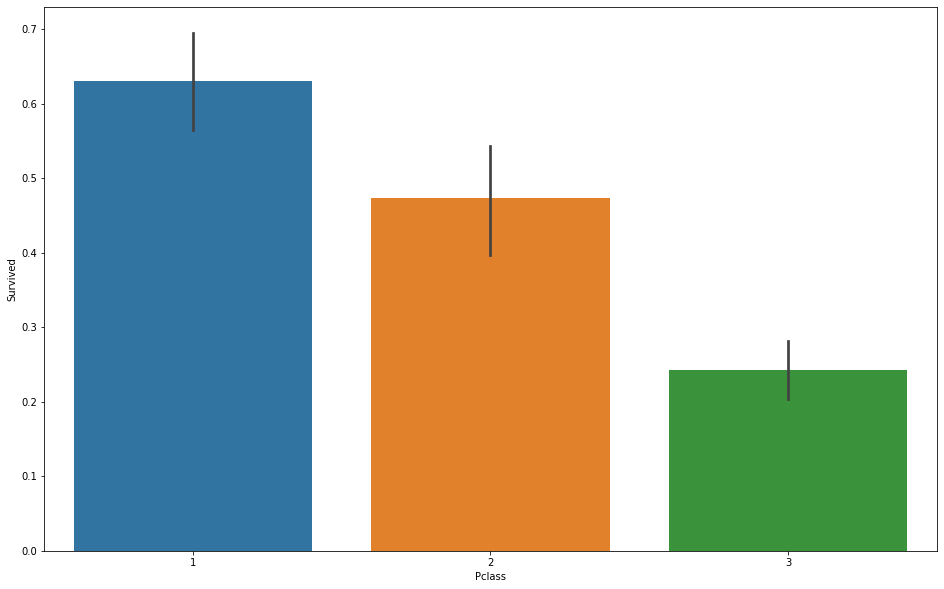

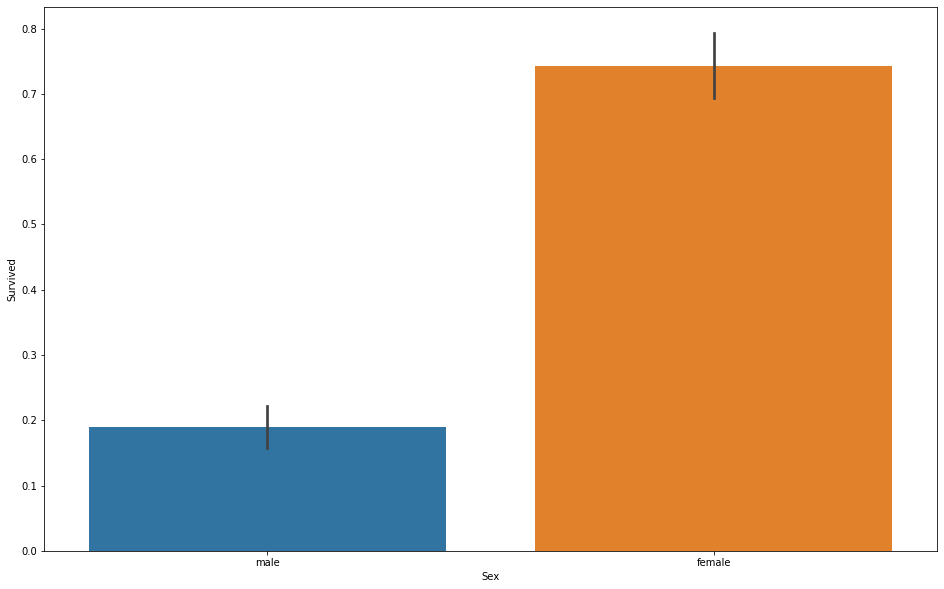

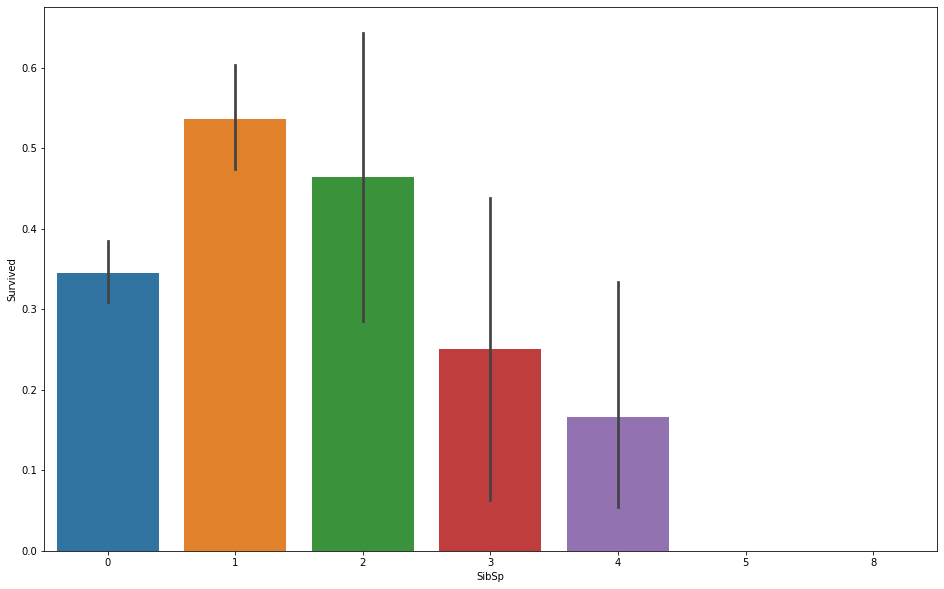

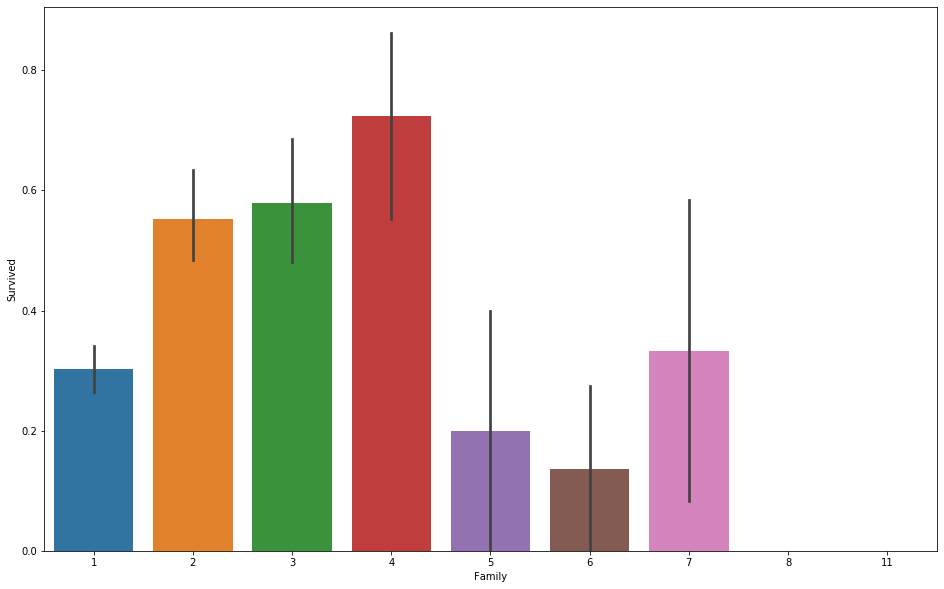

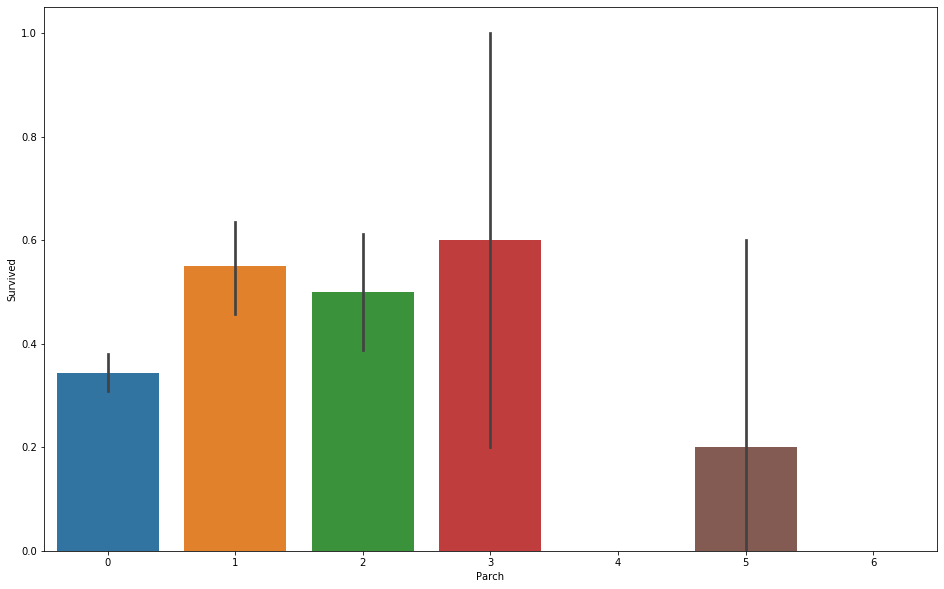

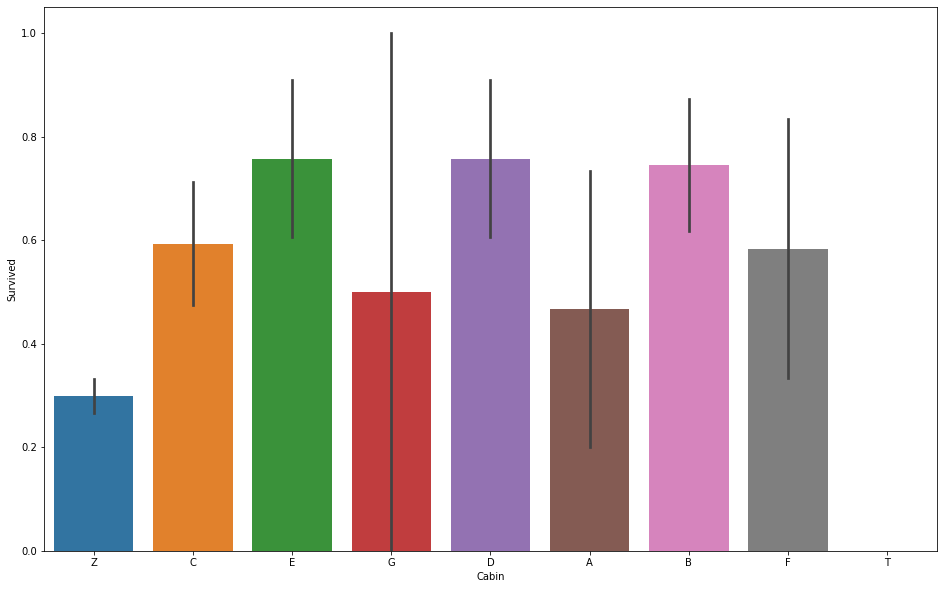

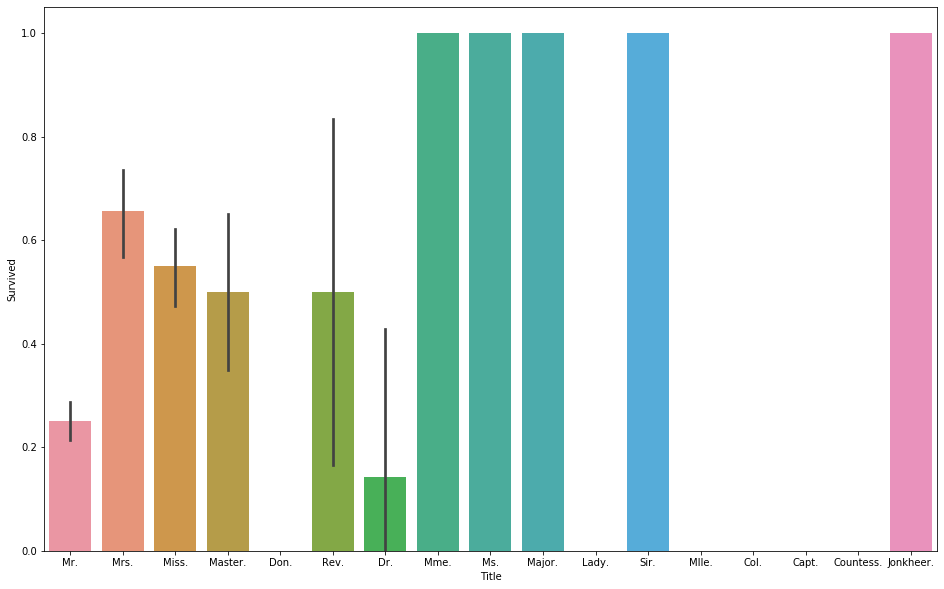

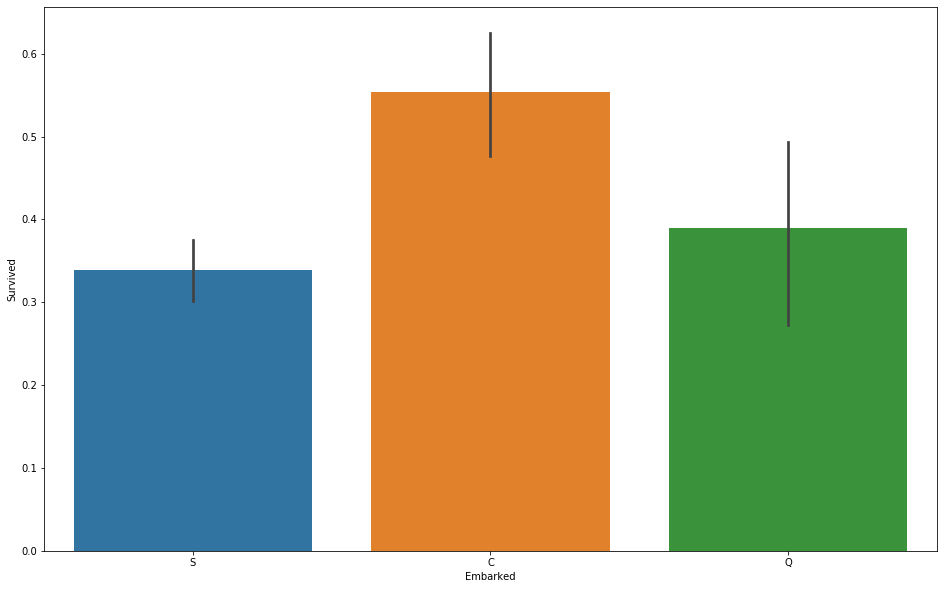

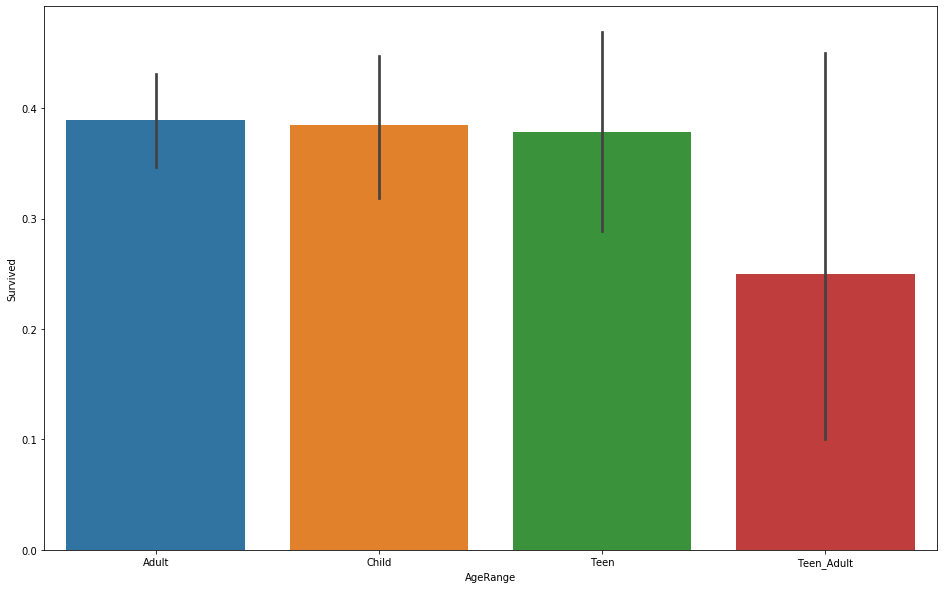

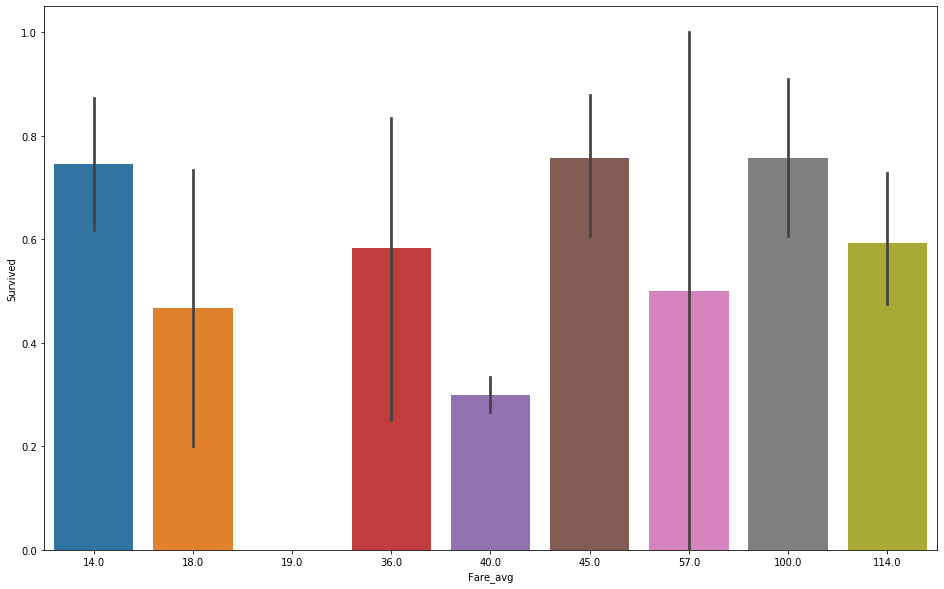

In [33]:
for i in ['Pclass', 'Sex', 'SibSp','Family',
          'Parch', 'Cabin', 'Title',
          'Embarked', 'AgeRange', 'Fare_avg']:
    plt.figure(figsize=(16, 10))
    sns.barplot(x=i,y='Survived',data=train)
    plt.show()

## Model

In [34]:
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
#import graphviz
from sklearn.metrics import confusion_matrix

In [35]:
seed = 42
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeRange', 'Fare_avg',
       'Title', 'male', 'female', 'Adult', 'Child', 'Teen', 'Teen_Adult', 'Z',
       'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T', 'Mr.', 'Mrs.', 'Miss.',
       'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.', 'Major.', 'Lady.',
       'Sir.', 'Mlle.', 'Col.', 'Capt.', 'Countess.', 'Jonkheer.', 'SE', 'CE',
       'QE', 'Family', '2F', '1F', '5F', '3F', '7F', '6F', '4F', '8F', '11F'],
      dtype='object')

In [36]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeRange', 'Fare_avg', 'Title',
       'male', 'female', 'Adult', 'Teen', 'Child', 'Teen_Adult', 'Z', 'B', 'E',
       'A', 'C', 'D', 'F', 'G', 'Mr.', 'Mrs.', 'Miss.', 'Master.', 'Ms.',
       'Col.', 'Rev.', 'Dr.', 'QE', 'SE', 'CE', 'Family', '1F', '2F', '3F',
       '5F', '4F', '6F', '8F', '7F', '11F'],
      dtype='object')

#### TODO: Reduce dimensionality

### Since this is a classification problem we can use D-Trees or random forest if this does not increase the acuracy from the baseline score then we can try other classification models

In [37]:
train = train.sample(frac=1).reset_index(drop=True)

clf = tree.DecisionTreeClassifier(random_state=seed,criterion='entropy')
features = ['Pclass','Family','male','Child',
            'Adult','Teen','Teen_Adult','Z','C','B',
            'D','E', 'SE', 'CE', 'QE','Mr.', 'Mrs.', 
            'Miss.', 'Master.', 'Ms.','Col.', 'Rev.', 
            'Dr.','1F', '2F', '3F','5F', '4F', '6F', 
            '8F', '7F', '11F']
X = train[features]
Y = train['Survived']
clf = clf.fit(X, Y)

#### Reason for feature selection:

In [38]:
# predict which passengers survived using the trained model
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_dt1.csv', index=False)

In [39]:
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

male          0.345865
Pclass        0.142865
Family        0.073035
Child         0.056593
Z             0.055972
CE            0.038180
Mr.           0.030320
Miss.         0.025124
2F            0.024575
3F            0.023233
4F            0.017944
E             0.017901
Mrs.          0.017719
1F            0.015950
B             0.015670
Teen          0.013744
Adult         0.013443
Teen_Adult    0.013067
7F            0.010616
Master.       0.009236
QE            0.009082
SE            0.007577
C             0.006663
Dr.           0.005832
D             0.004857
6F            0.002680
5F            0.001645
Rev.          0.000613
Ms.           0.000000
Col.          0.000000
8F            0.000000
11F           0.000000
dtype: float64

### Decision tree is a base line model with a score of 75.60% accuracy (score from kaggle)
#### To improve from base score do parameter tunning for decision tree and also make a model for random forest

In [40]:
# shuffle
train = train.sample(frac=1).reset_index(drop=True)

train_val_X = train[features]
train_val_y = train['Survived']

print(len(train), len(test))
print(len(train_val_X),len(train_val_y))

891 418
891 891


Depth:  1
Training accuracy:  78.6755204311581 %
Validation accuracy:  78.67365513778168 %
Depth:  5
Training accuracy:  84.31524496903414 %
Validation accuracy:  80.35653756826314 %
Depth:  6
Training accuracy:  85.49364136344296 %
Validation accuracy:  80.12930763919404 %
Depth:  7
Training accuracy:  86.3353136769781 %
Validation accuracy:  81.02881175067479 %
Depth:  8
Training accuracy:  86.89648108167735 %
Validation accuracy:  80.46764170485218 %
Depth:  9
Training accuracy:  87.73823218872622 %
Validation accuracy:  79.68049714393321 %
Depth:  10
Training accuracy:  88.41160155695982 %
Validation accuracy:  79.34592932019335 %
Depth:  11
Training accuracy:  89.11317900310448 %
Validation accuracy:  79.00822296152154 %
Depth:  12
Training accuracy:  89.67426761428999 %
Validation accuracy:  79.12121021906974 %
Depth:  13
Training accuracy:  89.9269190160266 %
Validation accuracy:  79.2348251836043 %
Depth:  14
Training accuracy:  90.09530075484187 %
Validation accuracy:  79.1212

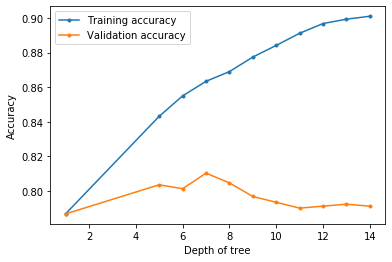

In [41]:
def dtc_parameter_tune(tain_val_X, train_val_y):
    depths = [1,5,6,7,8,9,10,11,12,13,14]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X.iloc[train_index,:]
            val_X = train_val_X.iloc[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = tree.DecisionTreeClassifier(max_depth=depth,random_state=seed,
                                              criterion='entropy')
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            
        avg_train_acc = sum(train_acc) / len(train_acc) # compute the average training accuracy of K-folds CV
        avg_val_acc = sum(val_acc) / len(val_acc) # compute the average validation accuracy of K-folds CV
        print("Depth: ", depth)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return depths, train_acc_all, val_acc_all

depths, train_acc_all, val_acc_all = dtc_parameter_tune(train_val_X,train_val_y)

# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

In [42]:
best_index = val_acc_all.index(max(val_acc_all))
best_depth = depths[best_index]
dtc = tree.DecisionTreeClassifier(max_depth=best_depth,random_state=seed,
                                  criterion='entropy')
dtc.fit(train_val_X,train_val_y)
train_acc = dtc.score(train_val_X, train_val_y)

print("Best depth: ", best_depth)
print("Training accuracy: ", train_acc * 100, "%")
print("mean accuracy", np.mean(val_acc_all)* 100, "%")

Best depth:  7
Training accuracy:  86.08305274971941 %
mean accuracy 79.6516226225598 %


In [43]:
# predict which passengers survived using the trained model
submit['Survived'] = dtc.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_dt_tuned.csv', index=False)

### Decision tree with tuned parameter is 78.89% accuracy (score from kaggle)

In [44]:
feature_imp = pd.Series(dtc.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

male          0.439988
Pclass        0.160831
Z             0.064768
Family        0.060020
Child         0.050422
3F            0.029555
CE            0.028191
Adult         0.018962
Mr.           0.018114
Teen_Adult    0.016623
E             0.016320
4F            0.014439
7F            0.013505
2F            0.012667
Master.       0.011749
B             0.010158
QE            0.009675
Teen          0.007762
Mrs.          0.005516
D             0.004103
6F            0.003409
Miss.         0.003223
8F            0.000000
5F            0.000000
Dr.           0.000000
C             0.000000
Rev.          0.000000
SE            0.000000
1F            0.000000
Ms.           0.000000
Col.          0.000000
11F           0.000000
dtype: float64

Estimator:  1
Training accuracy:  85.91455631372425 %
Validation accuracy:  76.08938547486035 %
Estimator:  2
Training accuracy:  85.9988259766456 %
Validation accuracy:  76.53945138409391 %
Estimator:  3
Training accuracy:  88.10300676048348 %
Validation accuracy:  77.7747787332873 %
Estimator:  4
Training accuracy:  88.24345619868572 %
Validation accuracy:  77.32659594501288 %
Estimator:  5
Training accuracy:  88.66429235545328 %
Validation accuracy:  77.32722365199925 %
Estimator:  6
Training accuracy:  88.97292654868652 %
Validation accuracy:  77.77603414726006 %
Estimator:  7
Training accuracy:  89.30969002631703 %
Validation accuracy:  77.66367459669826 %
Estimator:  8
Training accuracy:  89.53413335014261 %
Validation accuracy:  77.66304688971188 %
Estimator:  9
Training accuracy:  89.64637471043385 %
Validation accuracy:  78.11248509195907 %
Estimator:  10
Training accuracy:  89.61824542603652 %
Validation accuracy:  77.55068733915009 %
Estimator:  11
Training accuracy:  89.618

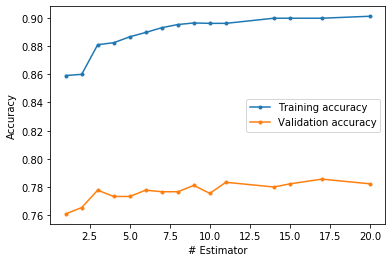

In [45]:
def clf_parameter_tune(tain_val_X, train_val_y):
    n_estimators = [1,2,3,4,5,6,7,8,9,10,11,14,15,17,20]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for estimator in n_estimators:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X.iloc[train_index,:]
            val_X = train_val_X.iloc[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            clf = RandomForestClassifier(n_estimators=estimator,random_state=seed,
                                         criterion='entropy')
            clf.fit(train_X, train_y)
            train_acc.append(clf.score(train_X, train_y))
            val_acc.append(clf.score(val_X, val_y))
            
        avg_train_acc = sum(train_acc) / len(train_acc) # compute the average training accuracy of K-folds CV
        avg_val_acc = sum(val_acc) / len(val_acc) # compute the average validation accuracy of K-folds CV
        print("Estimator: ", estimator)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return n_estimators, train_acc_all, val_acc_all

n_estimators, train_acc_all, val_acc_all = clf_parameter_tune(train_val_X, train_val_y)

# plot training/validation curves
plt.plot(n_estimators, train_acc_all, marker='.', label="Training accuracy")
plt.plot(n_estimators, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('# Estimator')
plt.ylabel('Accuracy')
plt.legend()

In [46]:
best_index = val_acc_all.index(max(val_acc_all))
best_estimator = n_estimators[best_index]
clf = RandomForestClassifier(n_estimators=best_estimator,random_state=seed,
                             criterion='entropy')
clf.fit(train_val_X,train_val_y)
train_acc = clf.score(train_val_X, train_val_y)

print("Best estimator: ", best_estimator)
print("Training accuracy: ", train_acc * 100, "%")
print("mean accuracy", np.mean(val_acc_all)* 100, "%")

Best estimator:  17
Training accuracy:  89.56228956228956 %
mean accuracy 77.6779863159877 %


In [47]:
# predict which passengers survived using the trained model
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_RF_tuned.csv', index=False)

### Result of random forest was 76.63%, need to do more parameter tuning for RF to imporve score

In [48]:
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

male          0.242230
Pclass        0.128330
Mr.           0.078081
Family        0.070362
Z             0.045242
Adult         0.038525
Child         0.037892
CE            0.030136
SE            0.027607
Mrs.          0.027323
Teen          0.025254
Miss.         0.024664
E             0.022881
1F            0.022138
C             0.021166
3F            0.020371
B             0.019471
D             0.017854
2F            0.016941
Master.       0.016860
QE            0.014652
4F            0.012451
Teen_Adult    0.010714
6F            0.007269
5F            0.004557
7F            0.004402
8F            0.003661
Dr.           0.003322
11F           0.002140
Rev.          0.001827
Col.          0.000940
Ms.           0.000737
dtype: float64

#### add boosting and ada boost model

In [49]:
# TODO: add tunning`
from sklearn.ensemble import AdaBoostClassifier
train = train.sample(frac=1).reset_index(drop=True)
X = train[features]
y = train['Survived']
clf = AdaBoostClassifier(n_estimators=100, random_state=seed)
clf.fit(X, y)
print(clf.score(X, y))
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_ADA_tuned.csv', index=False)

0.8181818181818182


In [50]:
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

Z             0.17
Pclass        0.16
C             0.08
D             0.07
E             0.07
B             0.06
Family        0.05
male          0.05
7F            0.03
Miss.         0.02
Child         0.02
SE            0.02
QE            0.02
Mr.           0.02
Master.       0.02
Dr.           0.02
3F            0.02
Col.          0.01
CE            0.01
Rev.          0.01
Ms.           0.01
2F            0.01
Mrs.          0.01
Teen_Adult    0.01
Teen          0.01
Adult         0.01
4F            0.01
1F            0.00
5F            0.00
6F            0.00
8F            0.00
11F           0.00
dtype: float64